# Sprint ディープラーニングフレームワーク1

## 1.このSprintについて

## Sprintの目的
・フレームワークのコードを読めるようにする  
・フレームワークを習得し続けられるようになる  
・理論を知っている範囲をフレームワークで動かす  

## どのように学ぶか
TensorFLowのサンプルコードを元に、これまで扱ってきたデータセットを学習していきます。

## 2.コードリーディング
TensorFLowによって2値分類を行うサンプルコードを載せました。今回はこれをベースにして進めます。

tf.kerasやtf.estimatorなどの高レベルAPIは使用していません。低レベルなところから見ていくことにします。

## 【問題1】スクラッチを振り返る
ここまでのスクラッチを振り返り、ディープラーニングを実装するためにはどのようなものが必要だったかを列挙してください。


（例）

・重みを初期化する必要があった  
・エポックのループが必要だった

それらがフレームワークにおいてはどのように実装されるかを今回覚えていきましょう。。

・活性化関数  
・勾配降下の最適化手法  
・ロス関数  
・各層のノード数等の設計  
     等々

## データセットの用意
以前から使用しているIrisデータセットを使用します。以下のサンプルコードではIris.csvが同じ階層にある想定です。


Iris Species


目的変数はSpeciesですが、3種類ある中から以下の2種類のみを取り出して使用します。

Iris-versicolor  
Iris-virginica


## 【問題2】スクラッチとTensorFlowの対応を考える

以下のサンプルコードを見て、先ほど列挙した「ディープラーニングを実装するために必要なもの」がTensorFlowではどう実装されているかを確認してください。


それを簡単に言葉でまとめてください。単純な一対一の対応であるとは限りません。


《サンプルコード》


＊バージョン1.5から1.14の間で動作を確認済みです。

In [141]:
import tensorflow as tf

print(tf.VERSION)  # tf.__version__でもよい

1.15.0


In [57]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)

# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)

# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# ★★　↓追加
tf.reset_default_graph()

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
    def __len__(self):
        return self._stop
    
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    
    def __iter__(self):
        self._counter = 0
        return self
    
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]
    
# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 20    # ★★　←epochs = 10 ⇒ 20 に変更
n_hidden1 = 50
n_hidden2 = 100
n_classes = 1
n_input = X_train.shape[1]
n_samples = X_train.shape[0]

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """
    # 重みとバイアスの宣言
    # ↓変更
    he_initializer1 = tf.initializers.he_normal()
    he_initializer2 = tf.initializers.he_normal()
    he_initializer3 = tf.initializers.he_normal()
    
    weights = {
        'w1': tf.get_variable(name = "W1", shape=[n_input, n_hidden1], initializer=he_initializer1),
        'w2': tf.get_variable(name = "W2", shape=[n_hidden1, n_hidden2], initializer=he_initializer2),
        'w3': tf.get_variable(name = "W3", shape=[n_hidden2, n_classes], initializer=he_initializer3),
    }    
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

# ネットワーク構造の読み込み                               
logits = example_net(X)

# 目的関数
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))

# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果
correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))

# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init = tf.global_variables_initializer()


# 計算グラフの実行
with tf.Session() as sess:     
    sess.run(init)       
    # ★★　↓グラフ表示用リスト追加
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        # ★★　↓追加
        total_val_loss = 0
        total_val_acc = 0
        
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            _, loss, acc = sess.run([train_op, loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
            total_loss += loss
            total_acc += acc
            # ★★　↓追加
            total_val_loss += val_loss
            total_val_acc += val_acc
            
        # ★★　↓ n_samples ⇒ total_batch へ変更
        total_loss /= total_batch
        total_acc /= total_batch
        total_val_loss /= total_batch
        total_val_acc /= total_batch
        
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch + 1, total_loss, total_val_loss, total_acc, total_val_acc))
        # ★★　↓ グラフ用リストに追加
        train_loss_list.append(total_loss)
        val_loss_list.append(total_val_loss)
        train_acc_list.append(total_acc)
        val_acc_list.append(total_val_acc)
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 2.0833, val_loss : 2.3007, acc : 0.550, val_acc : 0.518
Epoch 1, loss : 1.0761, val_loss : 0.7730, acc : 0.507, val_acc : 0.598
Epoch 2, loss : 0.3599, val_loss : 0.4206, acc : 0.814, val_acc : 0.768
Epoch 3, loss : 0.4084, val_loss : 0.2732, acc : 0.786, val_acc : 0.902
Epoch 4, loss : 0.2818, val_loss : 0.2584, acc : 0.871, val_acc : 0.893
Epoch 5, loss : 0.1525, val_loss : 0.1671, acc : 0.943, val_acc : 0.875
Epoch 6, loss : 0.1252, val_loss : 0.1103, acc : 0.971, val_acc : 1.000
Epoch 7, loss : 0.0976, val_loss : 0.1029, acc : 0.971, val_acc : 0.982
Epoch 8, loss : 0.1089, val_loss : 0.1021, acc : 0.957, val_acc : 0.964
Epoch 9, loss : 0.0933, val_loss : 0.0860, acc : 0.971, val_acc : 1.000
Epoch 10, loss : 0.0886, val_loss : 0.0880, acc : 0.971, val_acc : 1.000
Epoch 11, loss : 0.0836, val_loss : 0.0773, acc : 0.971, val_acc : 1.000
Epoch 12, loss : 0.0798, val_loss : 0.0769, acc : 0.986, val_acc : 1.000
Epoch 13, loss : 0.0779, val_loss : 0.0720, acc : 0.986, val_

Text(0, 0.5, 'Loss')

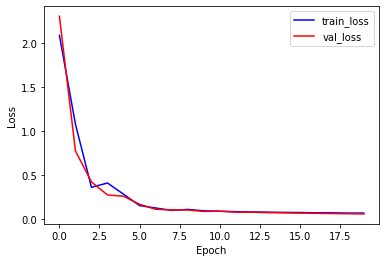

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss_list)), train_loss_list, color = "blue", label = "train_loss")
plt.plot(range(len(val_loss_list)), val_loss_list, color = "red", label = "val_loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

Text(0, 0.5, 'acc')

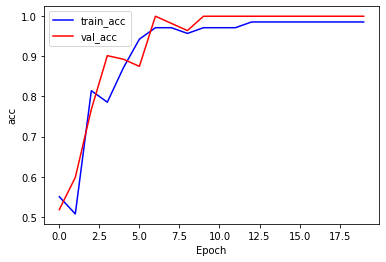

In [59]:
plt.plot(range(len(train_acc_list)), train_acc_list, color = "blue", label = "train_acc")
plt.plot(range(len(val_acc_list)), val_acc_list, color = "red", label = "val_acc")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("acc")

・＜活性化関数＞  
　⇒tf.nn.relu(layer_1)等で指定。
 
 
 
・＜勾配降下の最適化手法＞  
    ⇒optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)  
    　train_op = optimizer.minimize(loss_op)  
     
     
     
・＜ロス関数＞  
```python
# 目的関数
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))
```

で指定。tf.nn.sigmoid～を随時　別のロス関数に変更  
    
    
・＜各層のノード数等の設計＞  
```python
weights = {
    'w1': tf.get_variable(name = "W1", shape=[n_input, n_hidden1], initializer=he_initializer1),
    'w2': tf.get_variable(name = "W2", shape=[n_hidden1, n_hidden2], initializer=he_initializer2),
    'w3': tf.get_variable(name = "W3", shape=[n_hidden2, n_classes], initializer=he_initializer3),
}    
```
で指定。  



・＜重みの初期化＞  
initializerは、he_normal()の他に、  
glorot_normal()：Glorot の正規分布（Xavier の正規分布とも呼ばれます）による初期化を返します．  
glorot_uniform()：Glorot の一様分布（Xavier の一様分布とも呼ばれます）による初期化を返します．  
lecun_normal()：LeCunの正規分布による初期化．  
lecun_uniform()：LeCun の一様分布による初期化を返します．   
he_uniform()：He の一様分布による初期化を返します．   
・・・等。

## 3.他のデータセットへの適用
これまで扱ってきた小さなデータセットがいくつかあります。上記サンプルコードを書き換え、これらに対して学習・推定を行うニューラルネットワークを作成してください。


・Iris（3種類全ての目的変数を使用）  
・House Prices

どのデータセットもtrain, val, testの3種類に分けて使用してください。

## 【問題3】3種類全ての目的変数を使用したIrisのモデルを作成

Irisデータセットのtrain.csvの中で、目的変数Speciesに含まれる3種類全てを分類できるモデルを作成してください。


Iris Species


2クラスの分類と3クラス以上の分類の違いを考慮してください。それがTensorFlowでどのように書き換えられるかを公式ドキュメントなどを参考に調べてください。


《ヒント》


以下の2箇所は2クラス分類特有の処理です。
```python
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))

correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
```

メソッドは以下のように公式ドキュメントを確認してください。


tf.nn.sigmoid_cross_entropy_with_logits  |  TensorFlow


tf.math.sign  |  TensorFlow


＊tf.signとtf.math.signは同じ働きをします。

In [5]:
# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
df

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


In [142]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder 

# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)

# データフレームから条件抽出
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)

# ラベルを数値に変換
y[y=='Iris-setosa'] = 0
y[y=='Iris-versicolor'] = 1
y[y=='Iris-virginica'] = 2
y = y.astype(np.int)[:, np.newaxis]
print("y.shape = ", y.shape)

# one-hot-vectol化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
#y_train_one_hot = enc.fit_transform(y[:, np.newaxis])
y_train_one_hot = enc.fit_transform(y)

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y_train_one_hot, test_size=0.2, random_state=0)

# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

tf.reset_default_graph()

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
    def __len__(self):
        return self._stop
    
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    
    def __iter__(self):
        self._counter = 0
        return self
    
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]
    
# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 20
n_hidden1 = 50
n_hidden2 = 100
n_classes = 3
n_input = X_train.shape[1]
n_samples = X_train.shape[0]


# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """
    # 重みとバイアスの宣言
    he_initializer1 = tf.initializers.he_normal()
    he_initializer2 = tf.initializers.he_normal()
    he_initializer3 = tf.initializers.he_normal()
    
    weights = {
        'w1': tf.get_variable(name = "W1", shape=[n_input, n_hidden1], initializer=he_initializer1),
        'w2': tf.get_variable(name = "W2", shape=[n_hidden1, n_hidden2], initializer=he_initializer2),
        'w3': tf.get_variable(name = "W3", shape=[n_hidden2, n_classes], initializer=he_initializer3),
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

# ネットワーク構造の読み込み 出力：logits                              
logits = example_net(X)

# 目的関数
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits))

# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定値
y_pred = tf.nn.softmax(logits)


# 推定結果
#                       Y:正解ラベル、              y_pred:推定ラベル
correct_pred = tf.equal(tf.argmax(Y, 1), tf.argmax(y_pred, 1))

# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init = tf.global_variables_initializer()


# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        total_val_loss = 0
        total_val_acc = 0
        
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            _, loss, acc = sess.run([train_op, loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
            total_loss += loss
            total_acc += acc
            total_val_loss += val_loss
            total_val_acc += val_acc            
            
        total_loss /= total_batch
        total_acc /= total_batch
        total_val_loss /= total_batch
        total_val_acc /= total_batch
        
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch + 1, total_loss, total_val_loss, total_acc, total_val_acc))
        train_loss_list.append(total_loss)
        val_loss_list.append(total_val_loss)
        train_acc_list.append(total_acc)
        val_acc_list.append(total_val_acc)
        
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

y.shape =  (150, 1)
Epoch 1, loss : 3.6603, val_loss : 3.1262, acc : 0.380, val_acc : 0.421
Epoch 2, loss : 0.7124, val_loss : 0.6501, acc : 0.690, val_acc : 0.683
Epoch 3, loss : 0.2358, val_loss : 0.4156, acc : 0.910, val_acc : 0.804
Epoch 4, loss : 0.1779, val_loss : 0.3566, acc : 0.930, val_acc : 0.829
Epoch 5, loss : 0.2081, val_loss : 0.3758, acc : 0.930, val_acc : 0.842
Epoch 6, loss : 0.1476, val_loss : 0.2890, acc : 0.940, val_acc : 0.892
Epoch 7, loss : 0.0991, val_loss : 0.2291, acc : 0.960, val_acc : 0.917
Epoch 8, loss : 0.0754, val_loss : 0.2074, acc : 0.950, val_acc : 0.925
Epoch 9, loss : 0.0693, val_loss : 0.2060, acc : 0.970, val_acc : 0.925
Epoch 10, loss : 0.0623, val_loss : 0.2024, acc : 0.970, val_acc : 0.925
Epoch 11, loss : 0.0563, val_loss : 0.2010, acc : 0.980, val_acc : 0.917
Epoch 12, loss : 0.0538, val_loss : 0.2025, acc : 0.980, val_acc : 0.921
Epoch 13, loss : 0.0526, val_loss : 0.2054, acc : 0.980, val_acc : 0.921
Epoch 14, loss : 0.0520, val_loss : 0.20

Text(0, 0.5, 'Loss')

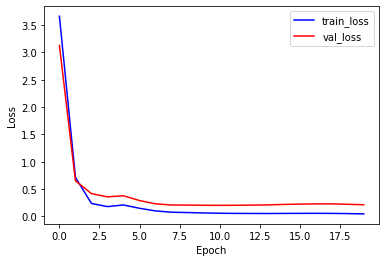

In [143]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss_list)), train_loss_list, color = "blue", label = "train_loss")
plt.plot(range(len(val_loss_list)), val_loss_list, color = "red", label = "val_loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

Text(0, 0.5, 'acc')

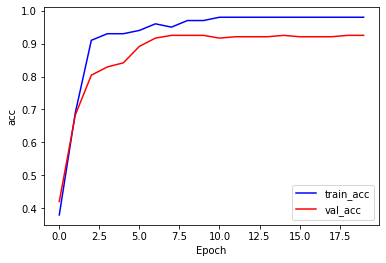

In [144]:
plt.plot(range(len(train_acc_list)), train_acc_list, color = "blue", label = "train_acc")
plt.plot(range(len(val_acc_list)), val_acc_list, color = "red", label = "val_acc")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("acc")

## 【問題4】House Pricesのモデルを作成
回帰問題のデータセットであるHouse Pricesを使用したモデルを作成してください。


House Prices: Advanced Regression Techniques


この中のtrain.csvをダウンロードし、目的変数としてSalePrice、説明変数として、GrLivAreaとYearBuiltを使ってください。説明変数はさらに増やしても構いません。


分類問題と回帰問題の違いを考慮してください。

In [115]:
dataset_path ="HousePrice_train.csv"
df = pd.read_csv(dataset_path)

df_data = df.loc[:,["GrLivArea","YearBuilt","SalePrice"]]
df_data

,GrLivArea,YearBuilt,SalePrice
0,1710,2003,208500
1,1262,1976,181500
2,1786,2001,223500
3,1717,1915,140000
4,2198,2000,250000
...,...,...,...
1455,1647,1999,175000
1456,2073,1978,210000
1457,2340,1941,266500
1458,1078,1950,142125


In [138]:
"""
TensorFlowで実装したニューラルネットワークを使いHousePriceデータセットの金額を回帰予想する
"""
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

# データセットの読み込み
dataset_path ="HousePrice_train.csv"
df = pd.read_csv(dataset_path)

df_data = df.loc[:,["GrLivArea","YearBuilt","SalePrice"]]


# 欠損値があるサンプル（行）は削除する。
drop_df = drop_df.dropna(axis=0)


# ndarrayへ変換
X = np.array(drop_df.iloc[:,0:2])
y = np.array(drop_df.iloc[:,2]).reshape(-1,1)

print("X.shape = ", X.shape)
print("y.shape = ", y.shape)

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

tf.reset_default_graph()

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
    def __len__(self):
        return self._stop
    
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    
    def __iter__(self):
        self._counter = 0
        return self
    
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]
    
# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 30
n_hidden1 = 100
n_hidden2 = 50
n_output = 1
n_input = X_train.shape[1]
n_samples = X_train.shape[0]

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_output])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """
    # 重みとバイアスの宣言
    he_initializer1 = tf.initializers.he_normal()
    he_initializer2 = tf.initializers.he_normal()
    he_initializer3 = tf.initializers.he_normal()
    
    weights = {
        'w1': tf.get_variable(name = "W1", shape=[n_input, n_hidden1], initializer=he_initializer1),
        'w2': tf.get_variable(name = "W2", shape=[n_hidden1, n_hidden2], initializer=he_initializer2),
        'w3': tf.get_variable(name = "W3", shape=[n_hidden2, n_output], initializer=he_initializer3),
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_output]))
    }
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

# ネットワーク構造の読み込み                               
logits = example_net(X)

# 目的関数
loss_op = tf.reduce_mean(tf.square(Y - logits))

# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果
#correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))

# 指標値計算 
RMSE = tf.sqrt(tf.reduce_mean(tf.square(Y - logits)))

# variableの初期化
init = tf.global_variables_initializer()

# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    train_loss_list = []
    val_loss_list = []
    train_rmse_list = []
    val_rmse_list = []
    
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_rmse = 0
        total_val_loss = 0
        total_val_rmse = 0
        
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            _, loss, rmse = sess.run([train_op, loss_op, RMSE], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            val_loss, val_rmse = sess.run([loss_op, RMSE], feed_dict={X: X_val, Y: y_val})
            total_loss += loss
            total_rmse += rmse
            total_val_loss += val_loss
            total_val_rmse += val_rmse            
            
        total_loss /= total_batch
        total_rmse /= total_batch
        total_val_loss /= total_batch
        total_val_rmse /= total_batch
        
        val_loss, val_rmse = sess.run([loss_op, RMSE], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, rmse : {:.3f}, val_rmse : {:.3f}".format(epoch + 1, total_loss, total_val_loss, total_rmse, total_val_rmse))
        train_loss_list.append(total_loss)
        val_loss_list.append(total_val_loss)
        train_rmse_list.append(total_rmse)
        val_rmse_list.append(total_val_rmse)        
    test_rmse = sess.run(RMSE, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_rmse))

X.shape =  (1460, 2)
y.shape =  (1460, 1)
Epoch 1, loss : 8482471430.8085, val_loss : 6566162971.2340, rmse : 77113.046, val_rmse : 72558.470
Epoch 2, loss : 3297328174.9787, val_loss : 2640848288.6809, rmse : 53473.811, val_rmse : 51344.705
Epoch 3, loss : 3173912278.4681, val_loss : 2602939037.9574, rmse : 52603.271, val_rmse : 50983.331
Epoch 4, loss : 3174405050.5532, val_loss : 2605064118.4681, rmse : 52615.217, val_rmse : 51003.388
Epoch 5, loss : 3174138628.7660, val_loss : 2608782480.3404, rmse : 52615.623, val_rmse : 51039.411
Epoch 6, loss : 3173984259.0638, val_loss : 2609557871.6596, rmse : 52612.004, val_rmse : 51047.144
Epoch 7, loss : 3173941209.1915, val_loss : 2607964263.4894, rmse : 52604.924, val_rmse : 51032.049
Epoch 8, loss : 3176026838.4681, val_loss : 2610231157.1064, rmse : 52624.700, val_rmse : 51053.752
Epoch 9, loss : 3176541403.5745, val_loss : 2610253834.8936, rmse : 52626.220, val_rmse : 51054.004
Epoch 10, loss : 3176404077.9574, val_loss : 2610807067.23

Text(0, 0.5, 'Loss')

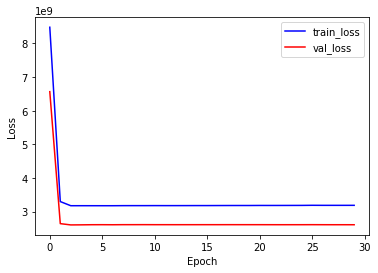

In [139]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss_list)), train_loss_list, color = "blue", label = "train_loss")
plt.plot(range(len(val_loss_list)), val_loss_list, color = "red", label = "val_loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

Text(0, 0.5, 'rmse')

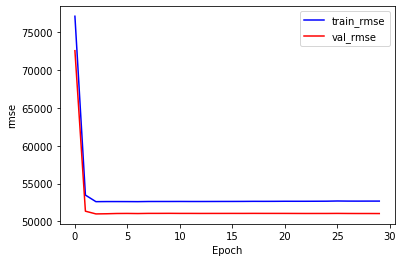

In [140]:
plt.plot(range(len(train_rmse_list)), train_rmse_list, color = "blue", label = "train_rmse")
plt.plot(range(len(val_rmse_list)), val_rmse_list, color = "red", label = "val_rmse")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("rmse")

## 【問題5】MNISTのモデルを作成
ニューラルネットワークのスクラッチで使用したMNISTを分類するモデルを作成してください。


3クラス以上の分類という点ではひとつ前のIrisと同様です。入力が画像であるという点で異なります。


スクラッチで実装したモデルの再現を目指してください。

In [109]:
"""
TensorFlowで実装したニューラルネットワークを使いMNISTデータセットを10値分類する
"""
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder 
from keras.datasets import mnist

# データセットの読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# one-hot-vectol化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train = enc.fit_transform(y_train[:, np.newaxis])
y_test = enc.fit_transform(y_test[:, np.newaxis])

X_train = X_train /255
X_test = X_test /255

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

tf.reset_default_graph()

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
    def __len__(self):
        return self._stop
    
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    
    def __iter__(self):
        self._counter = 0
        return self
    
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]
    
# ハイパーパラメータの設定
learning_rate = 0.0008
batch_size = 20
num_epochs = 20
n_hidden1 = 400
n_hidden2 = 200
n_classes = 10
n_input = X_train.shape[1]
n_samples = X_train.shape[0]

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """
    # 重みとバイアスの宣言
    he_initializer1 = tf.initializers.he_normal()
    he_initializer2 = tf.initializers.he_normal()
    he_initializer3 = tf.initializers.he_normal()
    
    weights = {
        'w1': tf.get_variable(name = "W1", shape=[n_input, n_hidden1], initializer=he_initializer1),
        'w2': tf.get_variable(name = "W2", shape=[n_hidden1, n_hidden2], initializer=he_initializer2),
        'w3': tf.get_variable(name = "W3", shape=[n_hidden2, n_classes], initializer=he_initializer3),
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である 
    
    return layer_output

# ネットワーク構造の読み込み 出力：logits                              
logits = example_net(X)

# 目的関数
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits))

# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

y_pred = tf.nn.softmax(logits)

# 推定結果
#                       Y:正解ラベル、              y_pred:推定ラベル
correct_pred = tf.equal(tf.argmax(Y, 1), tf.argmax(y_pred, 1))

# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init = tf.global_variables_initializer()

print("Learning Start!")
    
# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        total_val_loss = 0
        total_val_acc = 0
        
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            _, loss, acc = sess.run([train_op, loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})            
            total_loss += loss
            total_acc += acc
            total_val_loss += val_loss
            total_val_acc += val_acc            
            
        total_loss /= total_batch
        total_acc /= total_batch
        total_val_loss /= total_batch
        total_val_acc /= total_batch
        
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch + 1, total_loss, total_val_loss, total_acc, total_val_acc))
        train_loss_list.append(total_loss)
        val_loss_list.append(total_val_loss)
        train_acc_list.append(total_acc)
        val_acc_list.append(total_val_acc)
        
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))
    print("Learning Finish!")

Learning Start!
Epoch 1, loss : 0.2310, val_loss : 0.2188, acc : 0.931, val_acc : 0.933
Epoch 2, loss : 0.0898, val_loss : 0.1064, acc : 0.973, val_acc : 0.967
Epoch 3, loss : 0.0560, val_loss : 0.0989, acc : 0.982, val_acc : 0.971
Epoch 4, loss : 0.0406, val_loss : 0.1021, acc : 0.987, val_acc : 0.972
Epoch 5, loss : 0.0302, val_loss : 0.1078, acc : 0.990, val_acc : 0.973
Epoch 6, loss : 0.0263, val_loss : 0.1091, acc : 0.991, val_acc : 0.974
Epoch 7, loss : 0.0218, val_loss : 0.1122, acc : 0.993, val_acc : 0.975
Epoch 8, loss : 0.0206, val_loss : 0.1114, acc : 0.993, val_acc : 0.976
Epoch 9, loss : 0.0171, val_loss : 0.1121, acc : 0.994, val_acc : 0.977
Epoch 10, loss : 0.0138, val_loss : 0.1233, acc : 0.995, val_acc : 0.977
Epoch 11, loss : 0.0161, val_loss : 0.1251, acc : 0.995, val_acc : 0.977
Epoch 12, loss : 0.0152, val_loss : 0.1288, acc : 0.995, val_acc : 0.977
Epoch 13, loss : 0.0123, val_loss : 0.1352, acc : 0.996, val_acc : 0.978
Epoch 14, loss : 0.0134, val_loss : 0.1402, 

Text(0, 0.5, 'Loss')

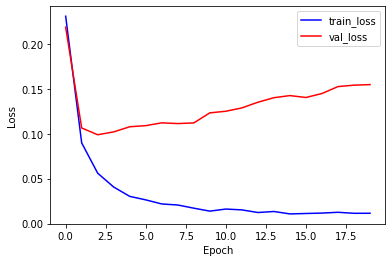

In [110]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss_list)), train_loss_list, color = "blue", label = "train_loss")
plt.plot(range(len(val_loss_list)), val_loss_list, color = "red", label = "val_loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

Text(0, 0.5, 'acc')

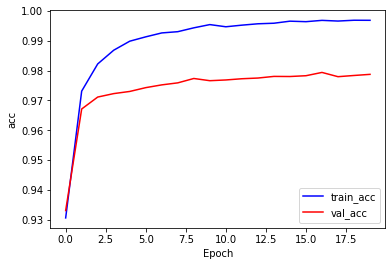

In [111]:
plt.plot(range(len(train_acc_list)), train_acc_list, color = "blue", label = "train_acc")
plt.plot(range(len(val_acc_list)), val_acc_list, color = "red", label = "val_acc")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("acc")